# **Project: Amazon Product Recommendation System**

# **Marks: 60**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model. 

--------------
## **Context**
--------------

E-commerce websites like Amazon, Flipkart uses different recommendation models to provide personalized suggestions to different users. For example, one of the recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective**
----------------

Build a recommendation system to recommend products to customers based on their previous ratings for other products.

-----------------------------
## **Dataset** 
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [90]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [7]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

### **Loading the data**

In [91]:
# Import the dataset
df = pd.read_csv('/content/drive/MyDrive/ratings_Electronics.csv', header = None) # There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] # Adding column names

df = df.drop('timestamp', axis = 1) # Dropping timestamp

df_copy = df.copy(deep = True) # Copying the data to another DataFrame

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product. 

In [9]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:        
        ratings_count[user] += 1
  
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [10]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [11]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:
    
    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1
    
    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1    

In [12]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [13]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis (6 marks)**

### **Shape of the data**

### **Question: Check the number of rows and columns and provide observations.**

In [14]:
# Check the number of rows and columns and provide observations
rows, columns = df_final.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  65290
No of columns:  3


**Observations:______**
- There are 65,290 observations and 3 columns in the data.

### **Data types**

### **Question: Check data types and provide observations.**

In [15]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Observations:______**
- The user id and product id are object data type
- Rating is the numeric data.

### **Checking for missing values**

### **Questions: Check for missing value in the data and provide observations.**

In [16]:
# Check for missing values present and provide observations
df_final.isnull()


,user_id,prod_id,rating
1310,False,False,False
1322,False,False,False
1335,False,False,False
1451,False,False,False
1456,False,False,False
...,...,...,...
7824423,False,False,False
7824424,False,False,False
7824425,False,False,False
7824426,False,False,False


**Observations:______**
- There's no missing values/

### **Summary Statistics**

### **Question: Summary statistics of 'rating' variable and provide observations.**

In [17]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].sum()

280408.0

**Observations:______**
- There are 280408 ratings in total.

### **Checking the rating distribution**

### **Question: Create the bar plot and provide observations.**

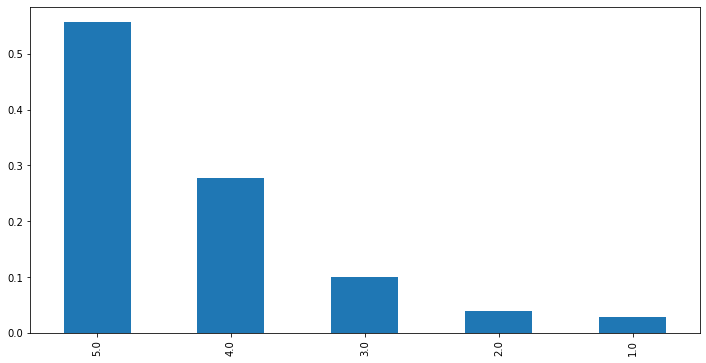

In [100]:
# Create the bar plot and provide observations
plt.figure(figsize = (12, 6))

df_final['rating'].value_counts(1).plot(kind = 'bar')

plt.show()

**Observations:________**
- We can see that products are liked by the majority of users, as the count of ratings 5 and 4 is higher than the count of lower ratings.
- There are a few products disliked by the users, the total sum of 2.0 and 1 is less than 0.1.

### **Checking the number of unique users and items in the dataset**

In [19]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df_final['prod_id'].nunique())

Number of unique USERS in Raw data =  1540
Number of unique ITEMS in Raw data =  5689


- There are **1540 unique users and 5689 products** in the dataset.

### **Users with the most number of ratings**

In [20]:
# Top 10 users based on the number of ratings
most_rated = df_final.groupby('user_id').size().sort_values(ascending = False)[:10]
most_rated

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64

- The highest number of **ratings by a user is 295** which is far from the actual number of products present in the data. We can build a recommendation system to recommend products to users which they have not interacted with.

## **Data Preparation  (2 Marks)**

### **Question: Check the number of unique USERS and PRODUCTS in the final data and provide observations.**

In [21]:
# Check the number of unique USERS and PRODUCTS in the final data and provide observations
print('The number of observations in the final data = ', len(df_final))

print('Number of unique USERS in the final data = ', df_final['user_id'].nunique)

print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique)

The number of observations in the final data =  65290
Number of unique USERS in the final data =  <bound method IndexOpsMixin.nunique of 1310       A3LDPF5FMB782Z
1322       A1A5KUIIIHFF4U
1335       A2XIOXRRYX0KZY
1451        AW3LX47IHPFRL
1456       A1E3OB6QMBKRYZ
                ...      
7824423    A34BZM6S9L7QI4
7824424    A1G650TTTHEAL5
7824425    A25C2M3QF9G7OQ
7824426     A1E1LEVQ9VQNK
7824427    A2NYK9KWFMJV4Y
Name: user_id, Length: 65290, dtype: object>
Number of unique PRODUCTS in the final data =  <bound method IndexOpsMixin.nunique of 1310       1400501466
1322       1400501466
1335       1400501466
1451       1400501466
1456       1400501466
              ...    
7824423    B00LGQ6HL8
7824424    B00LGQ6HL8
7824425    B00LGQ6HL8
7824426    B00LGQ6HL8
7824427    B00LGQ6HL8
Name: prod_id, Length: 65290, dtype: object>


**Observations:_______**
- There are 1,310 unique users and 1,310 unique products in the dataset.
- As per the number of unique users and products, there is a possibility of 1310 * 1310 = 1,716,100 ratings in the dataset. But we only have 65,290 ratings, i.e., not every user has rated every product in the dataset, which is quite understandable. This creates the possibility of building a recommendation system to recommend products to the users which they have not interacted with.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Rank Based Recommendation System (10 marks)**

In [22]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


### Question:

- **Create the final_rating DataFrame (4 Marks)**
- **Complete the code to create the function top_n_products (4 Marks)**
- **Recommending top 5 products with 50 minimum interactions based on popularity (1 Mark)**
- **Recommending top 5 products with 100 minimum interactions based on popularity (1 Mark)**

In [23]:
# Calculate the average rating for each product 
average_rating = df_final.groupby('prod_id').mean()['rating']

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id').count()['rating']

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values('avg_rating',ascending=False)

# See the first five records of the "final_rating" dataset
final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [24]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions

def top_n_products(final_rating, n, min_interaction):
    
    # Finding products with minimum number of interactions
    recommendations =final_rating[final_rating['rating_count'] > min_interaction]
    
    # Sorting values with respect to average rating 
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)
    
    return recommendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [25]:
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [26]:
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Collaborative Filtering Recommendation System**

In this type of recommendation system, `we do not need any information` about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example - 
<ol>
    <li><b>Ratings</b> provided by users. For example, ratings of books on goodread, movie ratings on imdb, etc.</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos.</li>
    <li><b>Use/buying</b> of a product by users. For example, buying different items on e-commerce sites.</li>
    <li><b>Reading</b> of articles by readers on various blogs.</li>
</ol>

**Types of Collaborative Filtering**

- Similarity/Neighborhood based

 * User-User Similarity Based  
 * Item-Item similarity based

- Model based

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [27]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating (here 3.5)** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold (here 3.5) is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them. 

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [28]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)
    
    print('Precision: ', precision) # Command to print the overall precision
    
    print('Recall: ', recall) # Command to print the overall recall
    
    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 is taken for the recommended and relevant ratings**. 
- In the **present case, precision and recall both need to be optimized as the service provider would like to minimize both the losses discussed** above. Hence, the correct performance measure is the **F_1 score**. 

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [29]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [31]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

- Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.
- **KNNBasic** is an algorithm that is also **associated with the surprise package**. It is used to find the **desired similar items among a given set of items**.

### **Question :** Build the user-user similarity-based recommendation system (5 Marks)

- **Initialize the KNNBasic model using sim_options provided, Verbose=False, and setting random_state=1 (1 Mark)**

- **Fit the model on the training data (1 Mark)**

- **Use the precision_recall_at_k function to calculate the metrics on the test data (1 Mark)**

- **Provide your observations on the output (2 Marks)** 

In [32]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options provided, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


**Observations:__________**
- We have calculated RMSE to check how far the overall predicted ratings are from the actual ratings.
- Intuition of Recall: We are getting a recall of ~0.858, which means out of all the relevant products 85.8% are recommended.
Intuition of Precision: We are getting a precision of ~ 0.855, which means out of all the recommended products 85.5% are relevant.
- Here F_1 score of the baseline model is ~0.856. It indicates that mostly recommended products were relevant and relevant products were recommended. 

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5 which is denoted by the parameter r_ui.

In [33]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

- The above output shows that **the actual rating for this user-item pair is 5, and the predicted rating is 3.40** by this **user-user-similarity-based baseline model**.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [34]:
df_final[df_final.prod_id == "1400501466"].user_id.unique()

array(['A3LDPF5FMB782Z', 'A1A5KUIIIHFF4U', 'A2XIOXRRYX0KZY',
       'AW3LX47IHPFRL', 'A1E3OB6QMBKRYZ', 'A19N3S7CBSU6O7'], dtype=object)

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this user id is not a part of the above list.

Below we are **predicting rating for the same `userId=A34BZM6S9L7QI4` but for a product which this user has not seen yet i.e. `prod_id=1400501466`** 

In [35]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

- The **predicted rating for this user is around 4.3** based on this **user-user similarity-based baseline model**.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithms. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [36]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9717702718752849
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters** as shown above.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [37]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 40, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9526
Precision:  0.847
Recall:  0.894
F_1 score:  0.87


- We can observe that after tuning hyperparameters, **F_1 score of the tuned model is 0.87, which is slightly better than the baseline model**. Along with this, **the RMSE of the model has gone down as compared to the model before hyperparameter tuning**. Hence, we can say that the model performance has improved slightly after hyperparameter tuning.

Let's now **predict the rating for a user with `userId` = "A3LDPF5FMB782Z", and prod_id = 1400501466 with the optimized model as shown below**.

### **Question:**
- **Predict rating for the user with `userId`="A3LDPF5FMB782Z", and `prod_id`= 1400501466 using the optimized model (1 Mark)**
- **Predict rating for the same userId="A34BZM6S9L7QI4" but for a product with which this user has not interacted before, i.e., prod_id = 1400501466, by using the optimized model (1 Mark)**
- **Compare the output with the output from the baseline model (2 Marks)**

In [41]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466",r_ui=5,verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [42]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**____________
- The estimation of first one hasnn't been improved that much
- The estimation rate has been better tuned to a higher level of 4.29 compared with 3.4 at the beginning.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [92]:
# Here, 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0, 5)

[6, 7, 17, 26, 32]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [43]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended product ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')
    
    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

#### **Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [45]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)

In [46]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B000BQ7GW8,5
2,B001TH7GUU,5
3,B005ES0YYA,5
4,B00834SJSK,5


### **Correcting the Ratings and Ranking the above products**

While comparing the ratings of two products, it is not only the **ratings** that describe the **likelihood of the user to that product**. Along with the rating, the **number of users who have seen that product** also becomes important to consider. Due to this, we have calculated the **"corrected_ratings"** for each product. Commonly higher the **"rating_count" of a product more it is liked by users**. To interpret the above concept, a **product rated 4 with rating_count 3 is less liked in comparison to a product rated 3 with a rating count of 50**. It has been **empirically found that the likelihood of the product is directly proportional to the inverse of the square root of the rating_count of the product**.

In [47]:
def ranking_products(recommendations, final_rating):
  # Sort the products based on ratings count
  ranked_products = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending = False)[['rating_count']].reset_index()

  # Merge with the recommended products to get predicted ratings
  ranked_products = ranked_products.merge(pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings']), on = 'prod_id', how = 'inner')

  # Rank the products based on corrected ratings
  ranked_products['corrected_ratings'] = ranked_products['predicted_ratings'] - 1 / np.sqrt(ranked_products['rating_count'])

  # Sort the products based on corrected ratings
  ranked_products = ranked_products.sort_values('corrected_ratings', ascending = False)
  
  return ranked_products

**Note:** In the **above-corrected rating formula**, we can add the **quantity `1/np.sqrt(n)` instead of subtracting it to get more optimistic predictions**. But here we are **subtracting this quantity**, as there are some products with ratings 5 and **we can't have a rating more than 5 for a product**.

In [48]:
# Applying the ranking products function and sorting it based on corrected ratings
ranking_products(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B00834SJSK,101,5,4.900496
1,B001TH7GUU,78,5,4.886772
2,B000BQ7GW8,54,5,4.863917
3,B000067RT6,41,5,4.843826
4,B005ES0YYA,26,5,4.803884


### Item-Item Similarity-based collaborative filtering recommendation systems

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**. 

In [49]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


- The baseline model is giving a good F_1 score of ~ 84%. We will try to **improve this later by using GridSearchCV** by tuning different hyperparameters of this algorithm.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [50]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

- The above output shows that **the actual rating for this user-item pair is 5 and the predicted rating is 4.27** by this **item-item-similarity-based baseline model**.

Below we are **predicting rating for the same `userId = A34BZM6S9L7QI4` but for a product with which this user has not interacted yet, i.e., `prod_id = 1400501466`**.

In [51]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict("A34BZM6S9L7QI4", "1400501466",  r_ui = 5,verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

As we can see the **predicted rating for this user-item pair is good (around 4.3)** based on this **item-item similarity-based baseline model**.

#### Improving similarity-based recommendation system by tuning its hyperparameters

Below we will be **tuning hyperparameters for the `KNNBasic` algorithms**.

### Question: Hyperparameter tuning the item-item similarity-based model. (6 marks)
- Use the following values for the param_grid and tune the model. (3 Marks)
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure (2 Marks)
- Print the best score and best parameters (1 Mark)

In [76]:
# Setting up parameter grid to tune the hyperparameters
param_grid =  {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9747887585487202
{'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### Question: Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model. (5 Marks) 

In [77]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'item_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options , k = 30 , min_k = 3 , random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)
# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9590
Precision:  0.854
Recall:  0.881
F_1 score:  0.867


**Observations:__________**
- The F_1 score has been improved by 2.6%.
- RMSE has shrinked by 3.6%.
- Overall, the performance has been increased by this fine-tuned algorithm.

Let's us now predict **rating for an user with `userId = A3LDPF5FMB782Z` and for `prod_id = 1400501466`** with the **optimized model** as shown below:

In [93]:
sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.85   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.849056603773586, details={'actual_k': 5, 'was_impossible': False})

Below we are **predicting rating** for the same **`userId = A34BZM6S9L7QI4`** but for a product with which this user **has not interacted before**, i.e., `prod_id == 1400501466`, by using the optimized model as shown below:

In [94]:
sim_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

- For an unknown product the model is predicting a rating of **4.29**.

#### Identifying similar users to a given user (nearest neighbors)

We can also find out **similar users** to a given user or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar users to the user with internal id 0 based on the `msd` distance metric.

In [78]:
sim_item_item_optimized.get_neighbors(0, k = 5)

[6, 42, 44, 54, 66]

#### Predicted top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.

In [79]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [80]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B00005T3G0,5
1,B000067RT6,5
2,B0000B006W,5
3,B0000BZL1P,5
4,B0000X0VCY,5


In [81]:
# Applying the ranking products function and sorting it based on the corrected ratings 
ranking_products(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B0000BZL1P,44,5,4.849244
1,B000067RT6,41,5,4.843826
2,B00005T3G0,31,5,4.820395
3,B0000X0VCY,21,5,4.781782
4,B0000B006W,12,5,4.711325


* Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### Model-Based Collaborative Filtering - Matrix Factorization

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

### Question: Build the matrix factorization recommendation system (using random_state = 1) and provide your observations on the performance of the model. (4 Marks)

In [82]:
# Using SVD matrix factorization
svd = SVD(random_state = 1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


**Observations:___________**
- We can observe that the F_1 score for the matrix factorization model on the test set is lower in comparison to the F_1 score for the item-item-similarity recommendation system and optimized item-item similarity-based recommendation system. Whereas the RMSE has decreased which shows the prediction is close to the factual.

- Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466` as shown below.
- Here, the user has already rated the product.

In [95]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

As we can observe, **the actual rating** for this user-item pair is 5, and the predicted rating is **4.08** by this matrix **factorization-based baseline model**. It seems like we have under-estimated the rating. We will try to fix this later by **tuning the hyperparameters** of the model using GridSearchCV.

Below we are predicting rating for the same `userId = A34BZM6S9L7QI4` but for a product with which this user has not interacted before, i.e., `productId = 1400501466`, as shown below:

In [83]:
# Making prediction
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

We can see that the **estimated rating** for this **user-item pair** is 4.40 based on this **matrix factorization based baseline model**.

#### Improving matrix factorization based recommendation system by tuning its hyperparameters

In SVD, rating is predicted as: 

$$\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}$$

If user $u$ is unknown, then the bias $b_{u}$ and the factors $p_{u}$ are assumed to be zero. The same applies for item $i$ with $b_{i}$ and $q_{i}$.

To estimate all the unknown, we minimize the following regularized squared error:

$$\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^{2}+\lambda\left(b_{i}^{2}+b_{u}^{2}+\left\|q_{i}\right\|^{2}+\left\|p_{u}\right\|^{2}\right)$$

The minimization is performed by a very straightforward **stochastic gradient descent**:

$$\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}$$

There are many hyperparameters to tune in this algorithm, you can find a full list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [84]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8995914169677025
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}


Once the **grid search** is complete, we can get the **optimal values** for each of those hyperparameters, as shown above.

Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

### Question: Fit the SVD model using the hyperparameters from GridSearchCV (use random_state = 1) and compare the output with the baseline model. (5 Marks)

In [85]:
# Build the optimized SVD model using optimal hyperparameter search
svd_optimized = SVD(n_epochs = 30, lr_all = 0.01, reg_all = 0.2, random_state = 1)

# Train the algorithm on the trainset
svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8814
Precision:  0.853
Recall:  0.874
F_1 score:  0.863


**Observations:_____________**
- The RMSE has dropped 0.68% hence the prediction result is closer to the factual one.
- The recall has dipped by 0.6%, a slightly sluggish performance.
- F1 score has improved by 0.3%.
- In summary, the optimal effect is trivial.

Let's now predict a rating for a user with `userId = A3LDPF5FMB782Z` and `productId = 1400501466` with the optimized model as shown below.

### Question: 
- **Using the optimized svd model, predict rating for the user with `userId` = "A3LDPF5FMB782Z", and `prod_id` =  1400501466. (1 Mark)**
- **Predict rating for the same userId = "A34BZM6S9L7QI4" but for a product with which this user has not interacted before, i.e., prod_id = 1400501466, by using the optimized model. (1 Mark)**
- **Compare the output with the output from the baseline model. (2 Marks)**

In [86]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict( "A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.24   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.238900563954771, details={'was_impossible': False})

In [87]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.20   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.204418940307481, details={'was_impossible': False})

**Observations:**_____________
- The prediction accuracy of both hasn't been optimized that much.

### Question:
- **Get 5 recommendations for the user with user_id = 'A2XIOXRRYX0KZY' using the svd_optimized model. Hint: Use get_recommendations() function (2 Marks)**
- **Rank the recommendations on the basis of the correct ratings. Hint: Use ranking_products() function (2 Marks)**

In [102]:
# Get top 5 recommendations for user_id A2XIOXRRYX0KZY using "svd_optimized" algorithm
svd_recommendations = get_recommendations(df_final, 'A2XIOXRRYX0KZY', 5, svd_optimized)

In [103]:
# Ranking products based on the above recommendations
ranking_products(svd_recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B0033PRWSW,15,4.897396,4.639197
1,B0010Y414Q,11,4.922592,4.621080
2,B000JV9LUK,10,4.928989,4.612761
3,B00AR95ESC,9,4.918866,4.585533
4,B00065AO0K,5,4.912416,4.465202


### Conclusion (5 Marks)

**Write your conclusion here**

> In this case study, we built recommendation systems using four different algorithms. They are as follows:



*  Rank-based using averages 
*  User-User similarity-based collaborative filtering
*  Item-Item similarity-based collaborative filtering
*  Model-based collaborative filtering (matrix factorization)

\

- The surprise library was used to demonstrate"user-user similarity-based collaborative filtering," "item-item similarity-based collaborative filtering," and "model-based collaborative filtering (matrix factorization)" algorithms. For these algorithms, grid search cross-validation is used to find the optimal hyperparameters for the data, and related predictions are created using the optimal hyperparameters.

For performance evaluation of these models precision@k and recall@k are used. Using these two metrics, the F_1 score is calculated for each working model.
Overall, the user-user similarity-based recommendation system has given the best performance in terms of the F1-Score.
We can try to further improve the performance of these models using hyperparameter tuning.

\
We can also combine different recommendation techniques to build hybrid recommendation systems.